# Retrieval Augmented Generation (RAG)

This notebook demonstrates an example of using [LangChain](https://www.langchain.com/) to delvelop a Retrieval Augmented Generation (RAG) pattern. It uses Azure AI Document Intelligence as document loader, which can extracts tables, paragraphs, and layout information from pdf, image, office and html files. The output markdown can be used in LangChain's markdown header splitter, which enables semantic chunking of the documents. Then the chunked documents are indexed into Azure AI Search vectore store. Given a user query, it will use Azure AI Search to get the relevant chunks, then feed the context into the prompt with the query to generate the answer.

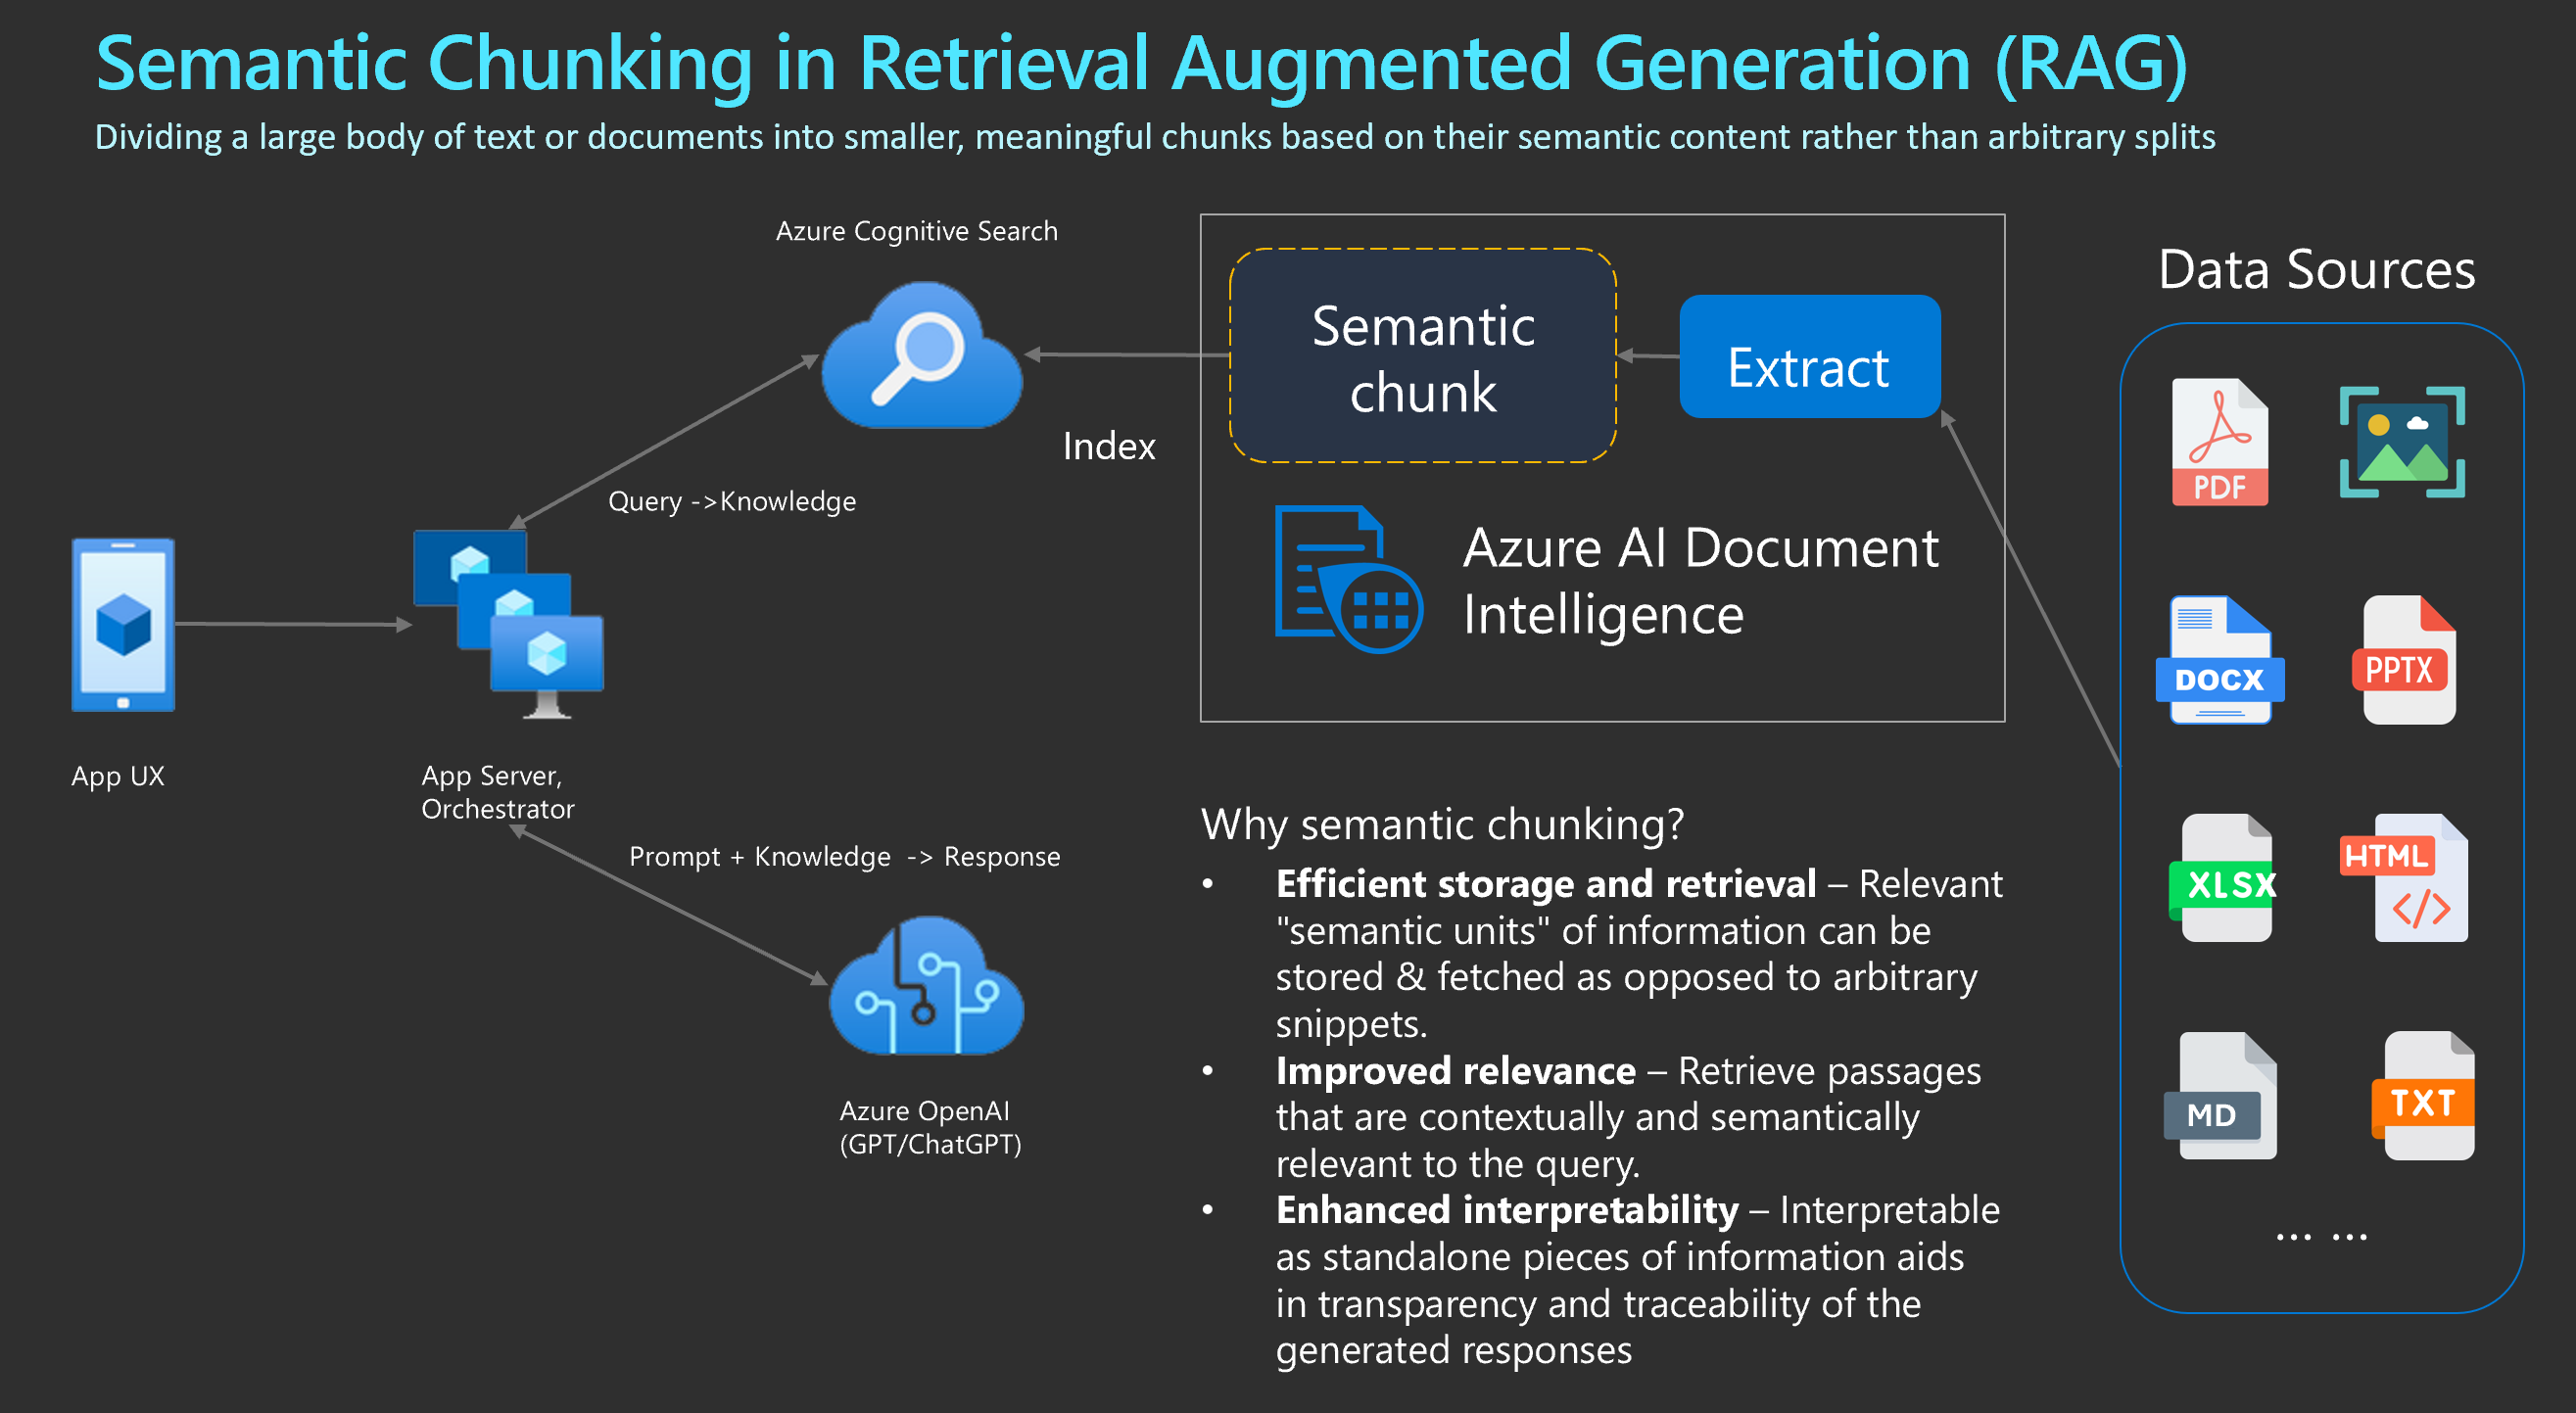


## Prerequisites
- An Azure AI Document Intelligence resource in one of the 3 preview regions: **East US**, **West US2**, **West Europe** - follow [this document](https://learn.microsoft.com/azure/ai-services/document-intelligence/create-document-intelligence-resource?view=doc-intel-4.0.0) to create one if you don't have.
- An Azure AI Search resource - follow [this document](https://learn.microsoft.com/azure/search/search-create-service-portal) to create one if you don't have.
- An Azure OpenAI resource and deployments for embeddings model and chat model - follow [this document](https://learn.microsoft.com/azure/ai-services/openai/how-to/create-resource?pivots=web-portal) to create one if you don't have.

We’ll use an Azure OpenAI chat model and embeddings and Azure AI Search in this walkthrough, but everything shown here works with any ChatModel or LLM, Embeddings, and VectorStore or Retriever.

## Setup

In [ ]:
! pip install python-dotenv langchain langchain-community langchain-openai langchainhub openai tiktoken azure-ai-documentintelligence azure-identity azure-search-documents==11.4.0b8

In [3]:
"""
This code loads environment variables using the `dotenv` library and sets the necessary environment variables for Azure services.
The environment variables are loaded from the `.env` file in the same directory as this notebook.
"""
import os

from dotenv import load_dotenv

load_dotenv()

os.environ["AZURE_OPENAI_ENDPOINT"] = os.getenv("AZURE_OPENAI_ENDPOINT")
os.environ["AZURE_OPENAI_API_KEY"] = os.getenv("AZURE_OPENAI_API_KEY")
doc_intelligence_endpoint = os.getenv("AZURE_DOCUMENT_INTELLIGENCE_ENDPOINT")
doc_intelligence_key = os.getenv("AZURE_DOCUMENT_INTELLIGENCE_KEY")

In [4]:
from langchain import hub
from langchain.schema import StrOutputParser
from langchain.schema.runnable import RunnablePassthrough
from langchain.text_splitter import MarkdownHeaderTextSplitter
from langchain.vectorstores.azuresearch import AzureSearch
from langchain_community.document_loaders import AzureAIDocumentIntelligenceLoader
from langchain_openai import AzureChatOpenAI, AzureOpenAIEmbeddings

## Load a document and split it into semantic chunks

In [ ]:
# Initiate Azure AI Document Intelligence to load the document. You can either specify file_path or url_path to load the document.
loader = AzureAIDocumentIntelligenceLoader(
    file_path="<path to your file>",
    api_key=doc_intelligence_key,
    api_endpoint=doc_intelligence_endpoint,
    api_model="prebuilt-layout",
)
docs = loader.load()

# Split the document into chunks base on markdown headers.
headers_to_split_on = [
    ("#", "Header 1"),
    ("##", "Header 2"),
    ("###", "Header 3"),
]
text_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on)

docs_string = docs[0].page_content
splits = text_splitter.split_text(docs_string)

print("Length of splits: " + str(len(splits)))

## Embed and index the chunks

In [ ]:
# Embed the splitted documents and insert into Azure Search vector store

aoai_embeddings = AzureOpenAIEmbeddings(
    azure_deployment="<Azure OpenAI embeddings model>",
    openai_api_version="<Azure OpenAI API version>",  # e.g., "2023-07-01-preview"
)

vector_store_address: str = os.getenv("AZURE_SEARCH_ENDPOINT")
vector_store_password: str = os.getenv("AZURE_SEARCH_ADMIN_KEY")

index_name: str = "<your index name>"
vector_store: AzureSearch = AzureSearch(
    azure_search_endpoint=vector_store_address,
    azure_search_key=vector_store_password,
    index_name=index_name,
    embedding_function=aoai_embeddings.embed_query,
)

vector_store.add_documents(documents=splits)

## Retrive relevant chunks based on a question

In [ ]:
# Retrieve relevant chunks based on the question

retriever = vector_store.as_retriever(search_type="similarity", search_kwargs={"k": 3})

retrieved_docs = retriever.invoke("<your question>")

print(retrieved_docs[0].page_content)

# Use a prompt for RAG that is checked into the LangChain prompt hub (https://smith.langchain.com/hub/rlm/rag-prompt?organizationId=989ad331-949f-4bac-9694-660074a208a7)
prompt = hub.pull("rlm/rag-prompt")
llm = AzureChatOpenAI(
    openai_api_version="<Azure OpenAI API version>",  # e.g., "2023-07-01-preview"
    azure_deployment="<your chat model deployment name>",
    temperature=0,
)


def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

## Document Q&A

In [ ]:
# Ask a question about the document

rag_chain.invoke("<your question>")

## Doucment Q&A with references

In [ ]:
# Return the retrieved documents or certain source metadata from the documents

from operator import itemgetter

from langchain.schema.runnable import RunnableMap

rag_chain_from_docs = (
    {
        "context": lambda input: format_docs(input["documents"]),
        "question": itemgetter("question"),
    }
    | prompt
    | llm
    | StrOutputParser()
)
rag_chain_with_source = RunnableMap(
    {"documents": retriever, "question": RunnablePassthrough()}
) | {
    "documents": lambda input: [doc.metadata for doc in input["documents"]],
    "answer": rag_chain_from_docs,
}

rag_chain_with_source.invoke("<your question>")